<a href="https://colab.research.google.com/github/Atit-Bashyal/Merkel_1/blob/main/Wind_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import math
import csv
from datetime import datetime
from datetime import timedelta
import time
import datetime 
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from time import time
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller,acf, pacf

from matplotlib.pylab import rcParams
from matplotlib.pyplot import figure

import xlrd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from itertools import product
import statsmodels.api as sm
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import datetime
from keras.callbacks import EarlyStopping
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler




%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
merkel_1 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Meckel_1.csv',parse_dates=[0],index_col=0)
merkel_4 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Meckel_4.csv',parse_dates=[0],index_col=0)
rens_3 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Reinsfeld_3.csv',parse_dates=[0],index_col=0)

In [ ]:
merkel_1 = merkel_1[['power','wind_speed','wind_direction']]
merkel_1 = merkel_1.reset_index()
merkel_1['t'] = (merkel_1['datetime'] - merkel_1['datetime'].min()) / (merkel_1['datetime'].max() - merkel_1['datetime'].min())

In [ ]:
import time
from datetime import datetime
import calendar
merkel_1['Month'] = [x.month for x in merkel_1['datetime']]

In [ ]:
def w_output(S,d,of):
  offset_angle  = math.radians(d-of)
  val = S*(np.cos(offset_angle))** 2
  return val

def w_sin(d):

  val = np.sin(d)
  return val

def w_cos(d):
  val = np.cos(d)
  return val

In [ ]:
merkel_1['wind_direction_sin'] = merkel_1.apply(lambda row: w_sin(row['wind_direction']), axis=1)
#merkel_1['time_sin_month'] = merkel_1.apply(lambda row: w_sin((360/12)*row['t']), axis=1)
merkel_1['wind_direction_cos'] = merkel_1.apply(lambda row: np.cos(row['wind_direction']), axis=1)
#merkel_1['time_cos_month'] = merkel_1.apply(lambda row: w_cos((360/12)*row['t']), axis=1)
merkel_1['wind_output_50'] = merkel_1.apply(lambda row: w_output(row['wind_speed'], row['wind_direction'], 50), axis=1)
merkel_1['wind_output_200'] = merkel_1.apply(lambda row: w_output(row['wind_speed'], row['wind_direction'], 200), axis=1)
data = merkel_1.set_index('datetime')

In [ ]:
data.head()

,power,wind_speed,wind_direction,t,Month,wind_direction_sin,wind_direction_cos,wind_output_50,wind_output_200
datetime,,,,,,,,,
2019-02-13 12:30:00,-0.003,0.8,233.0,0.000000,2,0.498739,0.866752,0.797809,5.626947e-01
2019-02-13 12:45:00,-0.003,0.8,358.0,0.000015,2,-0.141090,0.989997,0.303231,6.877359e-01
2019-02-13 13:00:00,-0.003,0.9,319.0,0.000031,2,-0.991775,0.127994,0.000274,2.115363e-01
2019-02-13 13:15:00,-0.003,0.8,290.0,0.000046,2,0.826846,0.562429,0.200000,2.999520e-33
2019-02-13 13:30:00,-0.003,0.8,270.0,0.000062,2,-0.176046,0.984382,0.469459,9.358222e-02


In [ ]:
def df_to_cnn_rnn_format(df, test_size=0.5, look_back=5, target_column='target', scale_X=True):
    """
    Input is a Pandas DataFrame. 
    Output is a np array in the format of (samples, timesteps, features).
    Currently this function only accepts one target variable.

    Usage example:

    # variables
    df = data # should be a pandas dataframe
    train_size = 0.5 # percentage to use for training
    target_column = 'c' # target column name, all other columns are taken as features
    scale_X = False
    look_back = 5 # Amount of previous X values to look at when predicting the current y value
    """
    df = df.copy()

    # Make sure the target column is the last column in the dataframe
    df['target'] = df[target_column] # Make a copy of the target column, this places the new 'target' column at the end of all the other columns
    df = df.drop(columns=[target_column]) # Drop the original target column
    
    target_location = df.shape[1] - 1 # column index number of target
    split_index = int(df.shape[0]*test_size) # the index at which to split df into train and test
    
    # ...train
    X_train = df.values[:split_index, :target_location]
    y_train = df.values[:split_index, target_location]

    # ...test
    X_test = df.values[split_index:, :target_location] # original is split_index:-1
    y_test = df.values[split_index:, target_location] # original is split_index:-1

    # Scale the features
    if scale_X:
        scalerX = MinMaxScaler()
        X_train = scalerX.fit_transform(X_train)
        X_test = scalerX.fit_transform(X_test)
        
    # Reshape the arrays
    samples = len(X_train)
    num_features = target_location # All columns before the target column are features

    samples_train = X_train.shape[0] - look_back
    X_train_reshaped = np.zeros((samples_train, look_back, num_features)) # Initialize the required shape with an 'empty' zeros array.
    y_train_reshaped = np.zeros((samples_train))

    for i in range(samples_train):
        y_position = i + look_back
        X_train_reshaped[i] = X_train[i:y_position]
        y_train_reshaped[i] = y_train[y_position]


    samples_test = X_test.shape[0] - look_back
    X_test_reshaped = np.zeros((samples_test, look_back, num_features))
    y_test_reshaped = np.zeros((samples_test))

    for i in range(samples_test):
        y_position = i + look_back
        X_test_reshaped[i] = X_test[i:y_position]
        y_test_reshaped[i] = y_test[y_position]
    
    return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped

In [ ]:
look_back = 18*4 # D -> 5, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1
train_size = 0.5

X_train, y_train, X_test, y_test = df_to_cnn_rnn_format(df=data, test_size=train_size, look_back=look_back, target_column='power', scale_X=True)


In [ ]:

X_train.shape

(32548, 72, 8)

In [ ]:
"""
Get the X_train and X_test datetime values
"""
split_index = int(data.shape[0]*train_size)

X_train_values = data[:split_index] # get the datetime values of X_train
X_test_values = data[split_index:] # get the datetime values of X_train

In [ ]:
X_train_values.shape, y_train.shape

((32620, 9), (32548,))

In [ ]:
X_test_values.shape, y_test.shape

((32620, 9), (32548,))

In [ ]:
datetime_difference = len(X_train_values) - len(y_train)
X_train_values = X_train_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_train_values.shape, y_train.shape

datetime_difference = len(X_test_values) - len(y_test)
X_test_values = X_test_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_test_values.shape, y_test.shape

((32548, 9), (32548,))

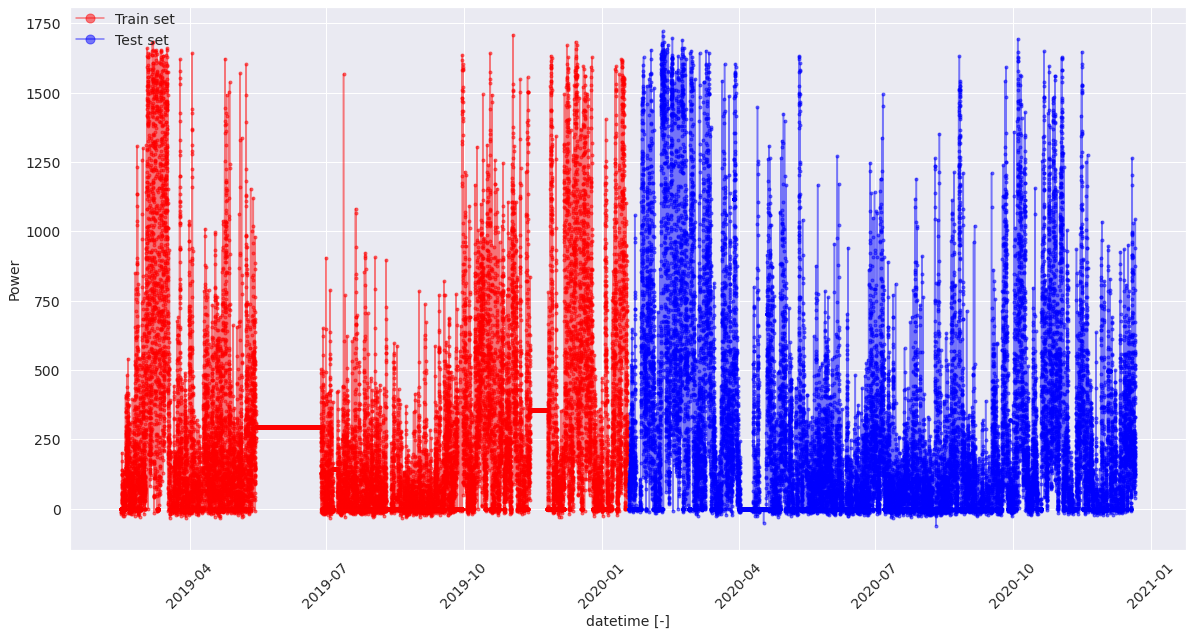

In [ ]:
"""
Create the plot
"""
plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'Power', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train.shape

(32548, 72, 8, 1)

In [ ]:
seed = 42



"""
For info on batch normalization: https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
CuDNN.... Use GPU implementations of .... model, this speeds up the training.
"""

from keras.layers import InputLayer, ConvLSTM2D, Reshape, GRU 
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD, Nadam

def create_model(X_train, y_train, X_test, y_test):
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    model = Sequential()
    
    ks1_first = 3
    ks1_second = 8
    
    ks2_first = 4
    ks2_second = 5
    
    model.add(Conv2D(filters=(3), 
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape, 
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.025))
    
    for _ in range(2):
        model.add(Conv2D(filters=(4), 
                     kernel_size= (ks2_first, ks2_second), 
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.280))  
    
    model.add(Flatten())
    
    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.435))
    
    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.372))
  
    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.793))
        
    model.add(Dense(1))
    
    return model

In [ ]:
"""
Look back , 5
nodes, 35

More only makes the model more complex and harder/slower to train
"""

epochs = 10
bs = 20
lr = 1e-3 #6e-4
print(bs)

20


In [ ]:
model = create_model(X_train, y_train, X_test, y_test)

# 0.05 0.9 0 True
sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)
nadam = Nadam(lr=lr)

# compile & fit
model.compile(optimizer='nadam', loss = ['mse'], metrics=['mse'])

In [ ]:

model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_split=0.2,verbose=1)

print(model.summary())

Epoch 1/10
1302/1302 [==============================] - 62s 44ms/step - loss: 84099.1350 - mse: 84099.1350 - val_loss: 76359.5156 - val_mse: 76359.5156
Epoch 2/10
1302/1302 [==============================] - 58s 44ms/step - loss: 36532.3358 - mse: 36532.3358 - val_loss: 94449.5156 - val_mse: 94449.5156
Epoch 3/10
1302/1302 [==============================] - 58s 44ms/step - loss: 35851.4153 - mse: 35851.4153 - val_loss: 76244.8359 - val_mse: 76244.8359
Epoch 4/10
1302/1302 [==============================] - 58s 44ms/step - loss: 34936.1408 - mse: 34936.1411 - val_loss: 77012.1953 - val_mse: 77012.1953
Epoch 5/10
1302/1302 [==============================] - 58s 44ms/step - loss: 33569.6539 - mse: 33569.6550 - val_loss: 64048.9531 - val_mse: 64048.9531
Epoch 6/10
1302/1302 [==============================] - 57s 44ms/step - loss: 32694.3965 - mse: 32694.3965 - val_loss: 69159.8906 - val_mse: 69159.8906
Epoch 7/10
1302/1302 [==============================] - 57s 44ms/step - loss: 33710.9775

In [ ]:
y_pred = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*train_size)
x = data[split_index:]

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

1018/1018 [==============================] - 19s 19ms/step - loss: 41055.8164 - mse: 41055.8164
FINISHED


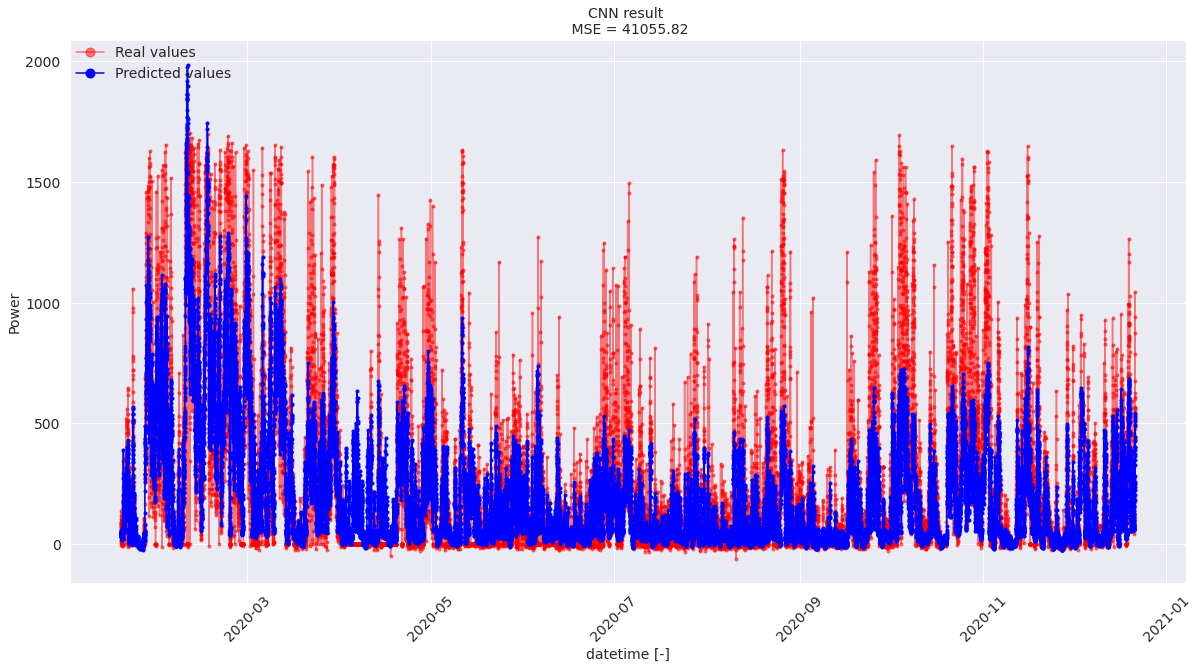

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'Power', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result = model.evaluate(X_test, y_test)

plt.title('CNN result \n MSE = %.2f' % (mse_result[0]), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')